In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from dependencies import Dependencies
from parse import Parse
from sklearn.metrics import accuracy_score

plt.style.use('seaborn-darkgrid')
from datetime import datetime as dt

import os
key = os.environ.get('quandl_api_key')

import quandl
quandl.ApiConfig.api_key = key

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

c:\Users\JB\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### OBJECTIVE

Investigate seasonal changes in WTI Crude and conversion to a potential alpha

TODO: 
1. Get an overview on average monthly change, grouped by month. 
2. Get an overview on average daily change, grouped by month. This should mirror the monthly change. 
3. Investigate probability distributions of the daily change per month. Ideally, a Gaussian Distribution would suggest that 
price movements during the specified period would be relatively stable.
4. Time Series breakdown on seasonality, stationarity. 
5. Create a backtest profile on based on monthly and daily changes. Calculate returns, and drawdown
6. Decide on limiting drawdown, by capping losses based on mean % loss for wrong trades. 
7. Summarize by creating a table on average daily returns. 
8. Validate Findings on a test dataset.

#### GETTING DATA FROM FRED VIA THE QUANDL API

In [ ]:
brent = 'FRED/DCOILBRENTEU'
wti = 'FRED/DCOILWTICO'

crude_d = quandl.get(wti)
crude_mon = quandl.get(wti, collapse = 'monthly')
crude_mon.columns = ['Close']
crude_mon['pct_change'] = crude_mon['Close'].pct_change() * 100
crude_mon = crude_mon.dropna()

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [ ]:
crude_mon_pct = crude_mon.drop('Close', axis = 1)
crude_mon_pct

,pct_change
Date,
1986-02-28,-30.184697
1986-03-31,-22.524565
1986-04-30,30.536585
1986-05-31,6.875934
1986-06-30,-10.489510
...,...
2022-01-31,18.359219
2022-02-28,7.817407
2022-03-31,4.577135


#### AVERAGE MONTHLY CHANGE

[Oil Seasonality](https://finance.yahoo.com/news/seasonality-impacts-crude-oil-prices-130529881.html)

Monthly change is calculated by calling the `pct_change` function, grouping the data by month, and calculating the mean. 

RATIONALE: 
Seasonality plays a key role in influencing crude oil prices. They tend to rise in August due to the summer driving season, fueling demand in gasoline, and tend to peak towards winter due to sluggish demand. Therefore, the tendency is for oil to become more expensive during seasons with high demand, and become cheaper on seasons with low demand (October - December).

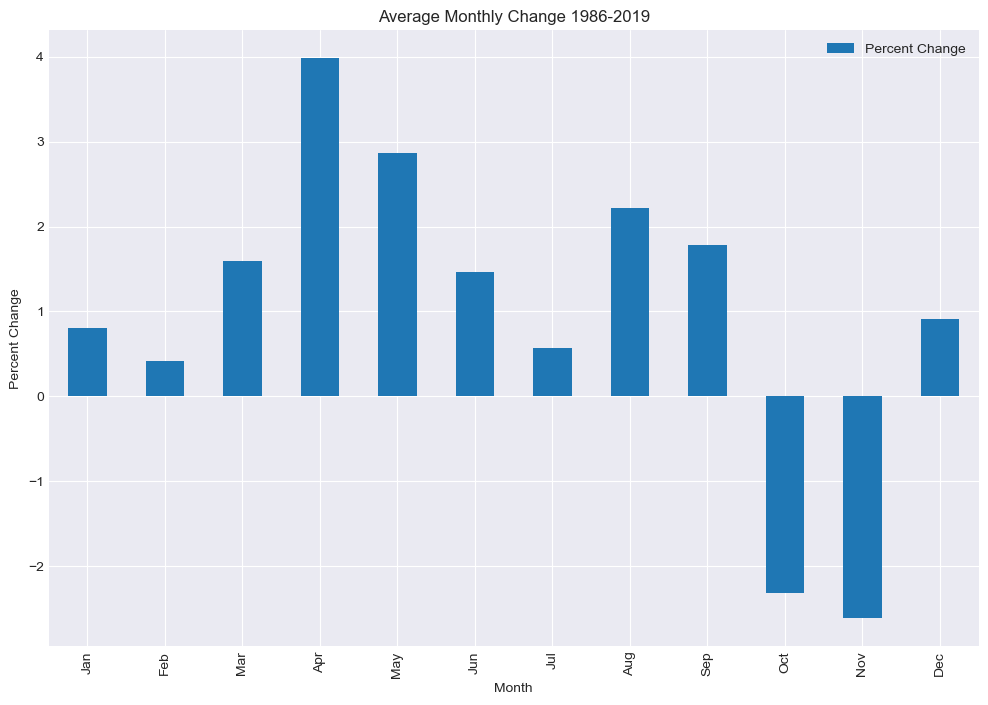

In [ ]:
grouped = crude_mon_pct.groupby(crude_mon_pct.index.month).mean()
grouped.index = grouped.index.map({k+1:v for k,v in enumerate(months)})
grouped.plot(kind = 'bar', grid = True, title = 'Average Monthly Change 1986-2019', figsize = (12, 8))
plt.ylabel('Percent Change')
plt.xlabel('Month')
plt.legend(labels = ['Percent Change'])

#### OBSERVATION 

The validity of seasonal changes in crude oil can be seen in the figure above, where it shows a negative average monthly change during winter season (October - November)

#### AVERAGE DAILY CHANGE

Average Daily change is calculated in a similar fashion to Monthly change. 

In [ ]:
crude_d.columns = ['Close']
crude_d['pct_change'] = crude_d['Close'].pct_change() * 100
crude_d = crude_d.dropna()

crude_d_pct = crude_d.drop('Close', axis = 1)

,Close,pct_change
Date,,
2020-04-20,-36.98,-301.966139


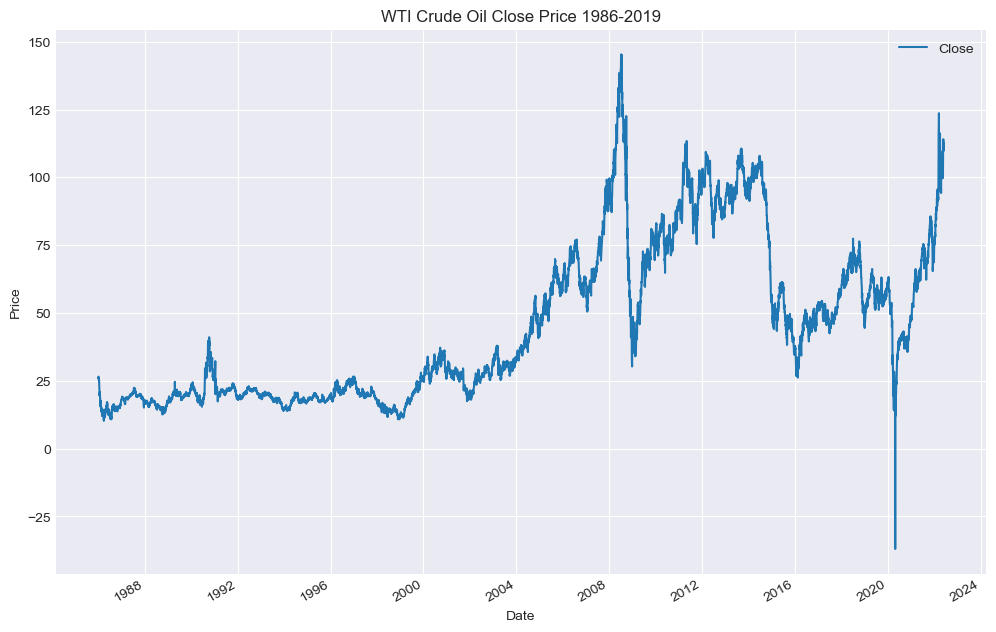

In [ ]:
plt.figure(figsize = (12, 8))
crude_d['Close'].plot()

plt.title('WTI Crude Oil Close Price 1986-2019')
plt.ylabel('Price')
plt.legend(labels = ['Close'])
crude_d.loc[crude_d['Close'] < 0]

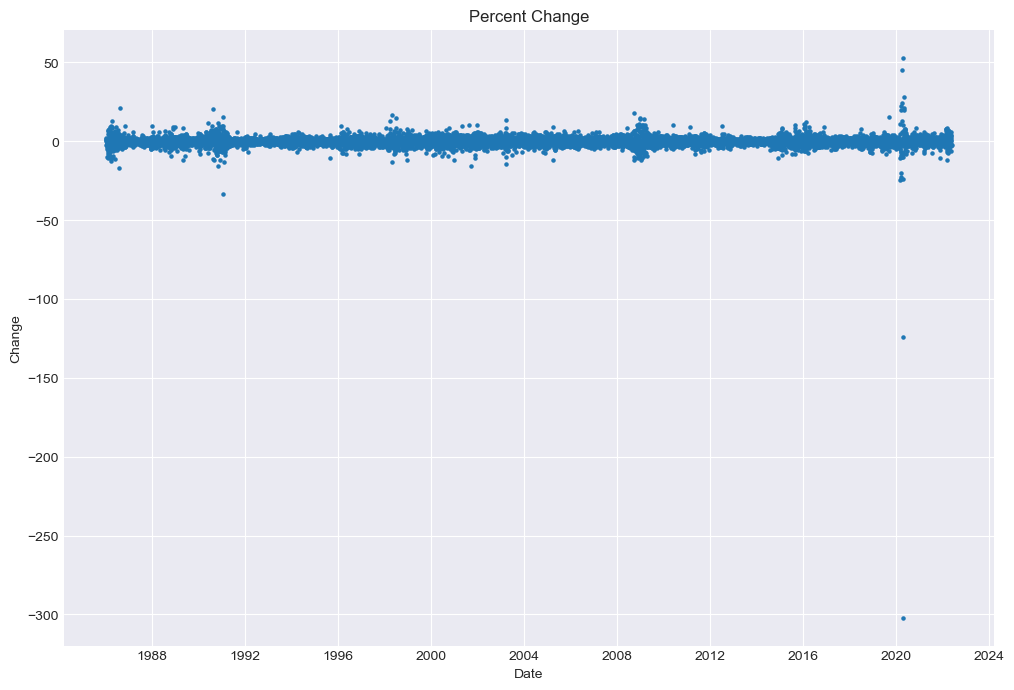

In [ ]:
plt.figure(figsize = (12, 8))
plt.scatter(crude_d.index, crude_d['pct_change'], s = 5)
plt.title('Percent Change')
plt.xlabel('Date')
plt.ylabel('Change')
plt.show()

#### ELIMINATING OUTLIERS

On April 20, 2020, Crude Oil closed at -36.98 USD, also known as the Great Oil Crash of 2020 was the first time Oil closed below 0. Would recommend to eliminate this since it does not constitute normal supply and demand conditions. 

Testing period would exclude 2020 onwards. 

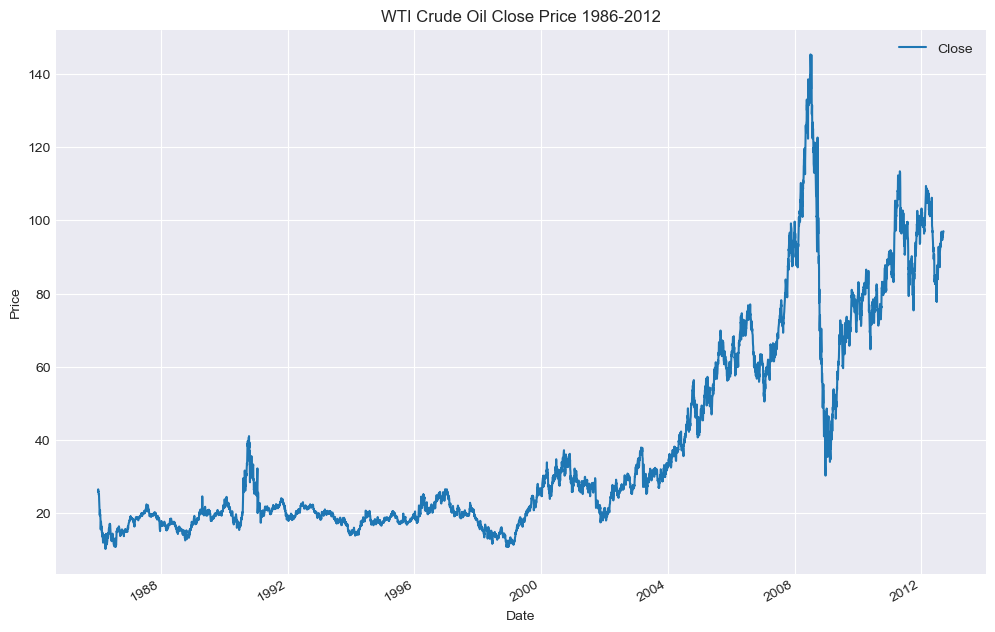

In [ ]:
#filtered_crude_d = crude_d[:8568].copy()
#filtered_crude_d = crude_d[crude_d.index < dt(2020, 1, 1)]
test_size = int(len(crude_d) * 0.2)
filtered_crude_d = crude_d.loc[crude_d.index < dt(2020,1,1)][:-test_size]

filtered_crude_d_pct = filtered_crude_d.drop('Close', axis = 1)
plt.figure(figsize = (12, 8))
filtered_crude_d['Close'].plot()
plt.ylabel('Price')
plt.title('WTI Crude Oil Close Price 1986-2012')
plt.legend(labels = ['Close'])

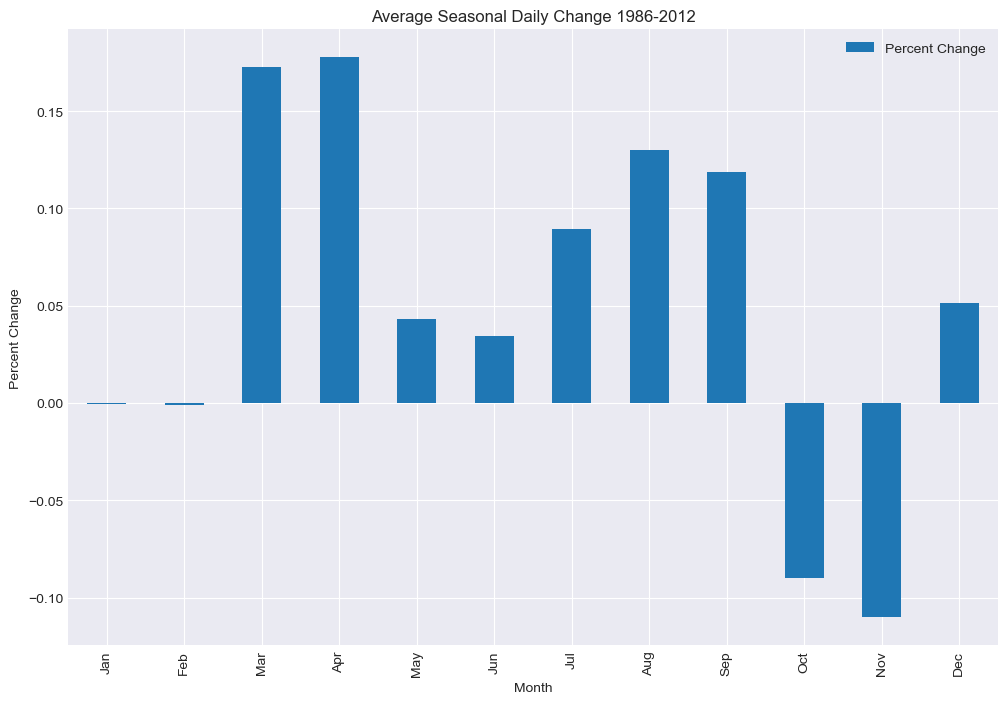

In [ ]:
grouped_d = filtered_crude_d_pct.groupby(filtered_crude_d_pct.index.month).mean()
grouped_d.index = grouped_d.index.map({k+1:v for k,v in enumerate(months)})
grouped_d.plot(kind = 'bar', grid = True, title = 'Average Seasonal Daily Change 1986-2012', figsize = (12, 8))
plt.ylabel('Percent Change')
plt.xlabel('Month')
plt.legend(labels = ['Percent Change'])

#### VOLATILITY

Volatility is observed to range between 2% to 4% for the duration of the whole year, except for the April reading where, due to the Flash Crash of Covid, displays relatively high volatility.

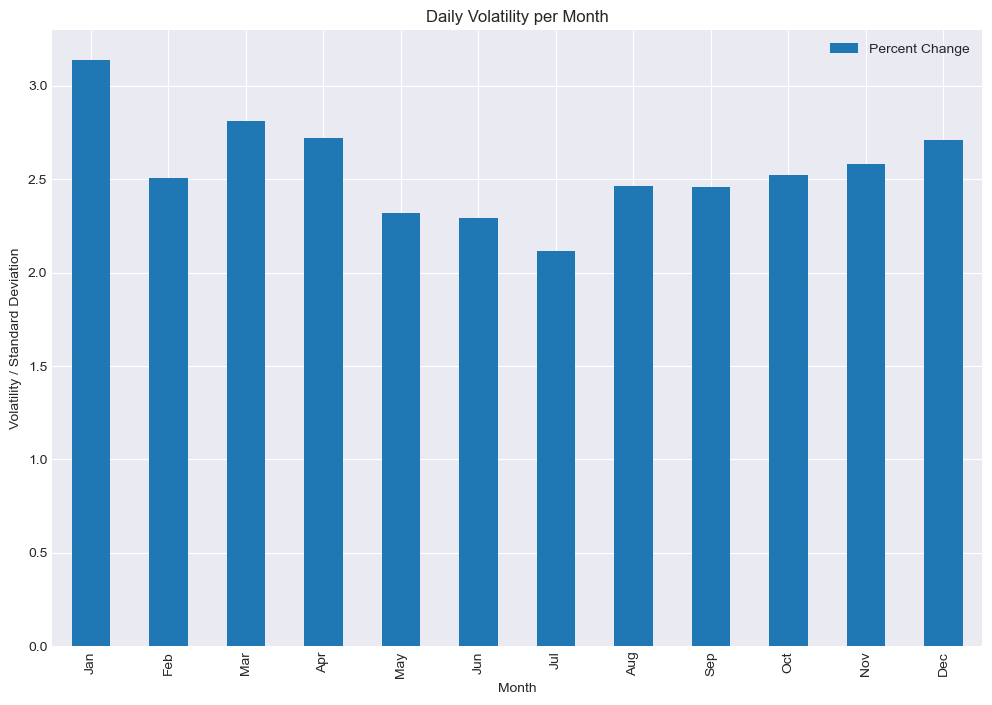

In [ ]:
volatility_d = filtered_crude_d_pct.groupby(filtered_crude_d_pct.index.month).std()
volatility_d.index = volatility_d.index.map({k+1:v for k,v in enumerate(months)})
volatility_d.plot(kind = 'bar', grid = True, title = 'Daily Volatility per Month', figsize = (12,8))
plt.ylabel('Volatility / Standard Deviation')
plt.xlabel('Month')
plt.legend(labels = ['Percent Change'])

### OBSERVATION

Investigating different time horizons shows relatively consistent results.

Other events that can affect oil prices would be geopolitical tensions, economic slowdown, financial crisis, war. 

#### ASSESSING THE PROBABILITY DISTRIBUTION OF AVERAGE DAILY CHANGE

For the entire dataset, the distribution of daily change appears to be a Gaussian Distribution, however, highly concentrated around 0. 

The figures reflect the measure of volatility from the previous figure. 

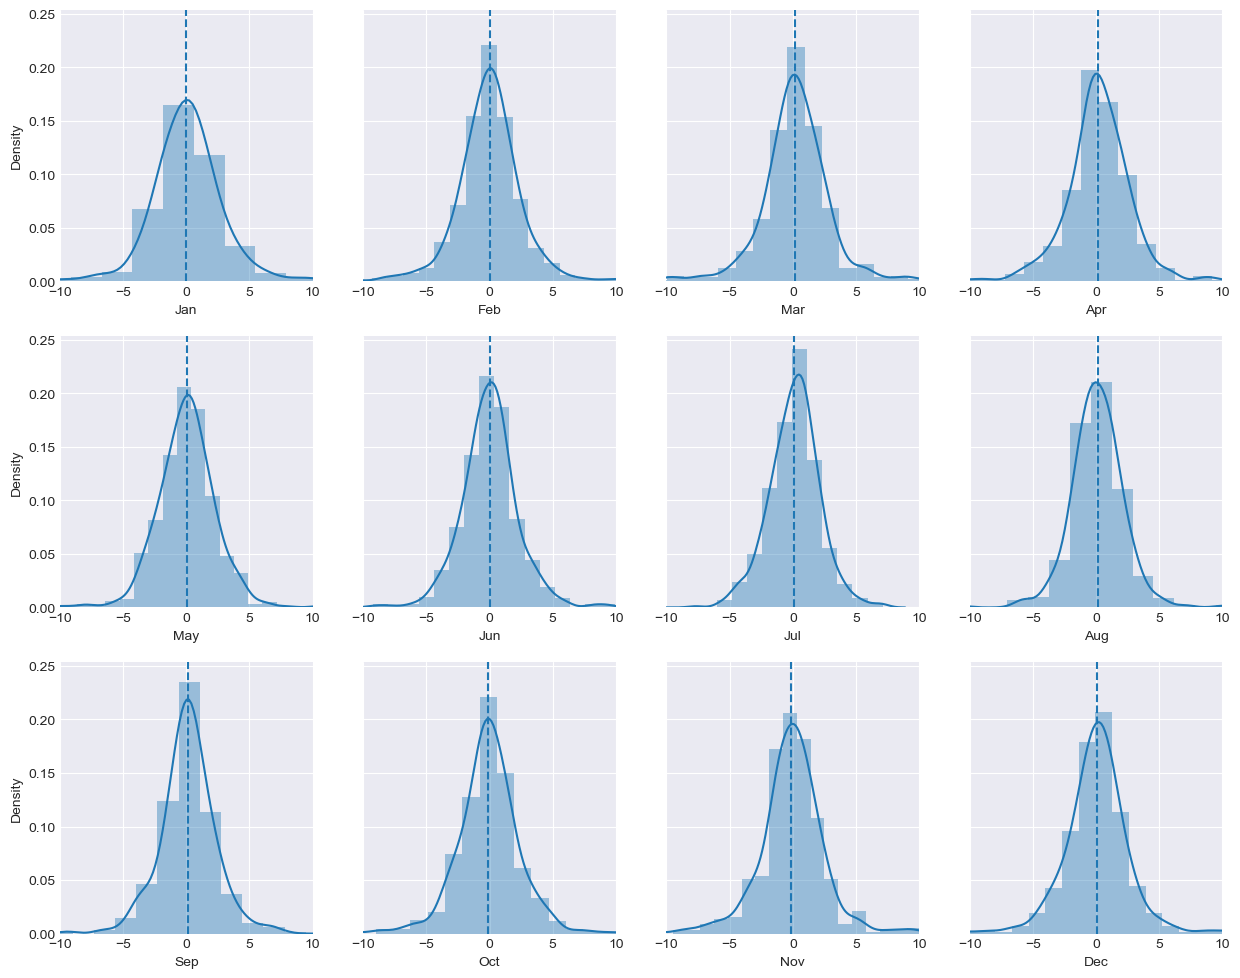

In [ ]:
fig, axes = plt.subplots(3, 4, sharey = True, sharex = False, figsize = (15, 12))
month_map = {j + 1 : m for j, m in enumerate(months)}

for i, ax in zip(months, axes.flat):
    
    data = filtered_crude_d.loc[filtered_crude_d.index.month.map({k+1:v for k,v in enumerate(months)}) == i]['pct_change']
    mean = data.mean()
    
    
    sns.distplot(data, ax = ax, bins = 20)
    ax.set_xlim(-10, 10)
    ax.set(xlabel = i)
    ax.axvline(mean, ls = '--')
 

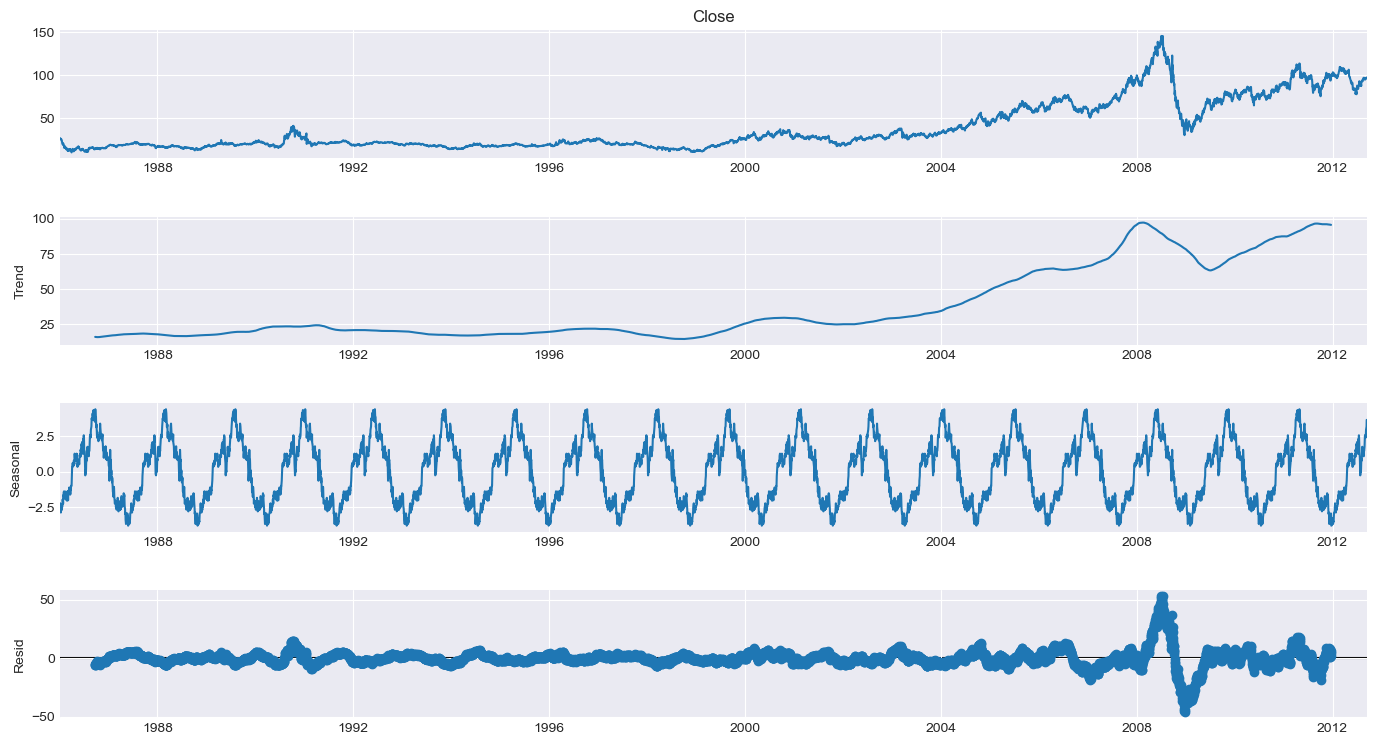

In [ ]:
res = sm.tsa.seasonal_decompose(filtered_crude_d['Close'], period = 365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
filtered_crude_d

,Close,pct_change
Date,,
1986-01-03,26.00,1.721440
1986-01-06,26.53,2.038462
1986-01-07,25.85,-2.563136
1986-01-08,25.87,0.077369
1986-01-09,26.03,0.618477
...,...,...
2012-09-06,95.58,0.220195
2012-09-07,96.41,0.868383
2012-09-10,96.52,0.114096


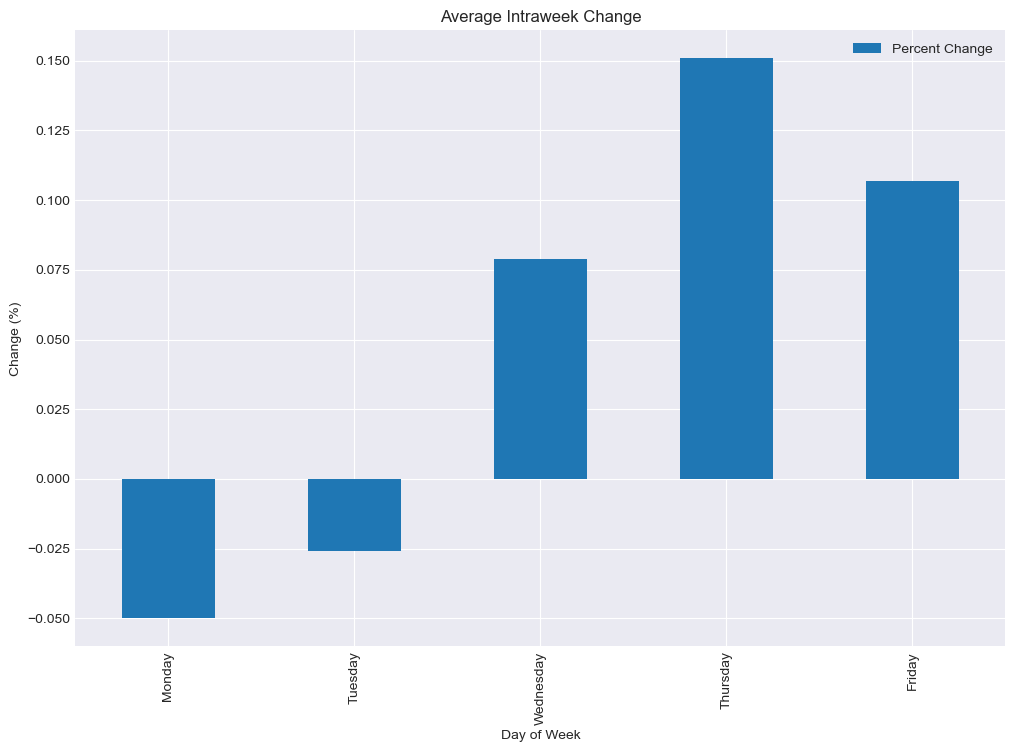

In [ ]:
f_grp = filtered_crude_d.groupby(filtered_crude_d.index.dayofweek)['pct_change'].mean()
f_grp.index = f_grp.index.map({k:v for k,v in enumerate(days)})
f_grp.plot(kind = 'bar', grid = True, title = 'Average Intraweek Change', figsize = (12, 8))
plt.ylabel('Change (%)')
plt.xlabel('Day of Week')
plt.legend(labels = ['Percent Change'])

#### BACKTESTING

Comparing actual market returns vs strategy returns, based on seasonality. The strategy would prefer Short positions on October, and November, and Long positions for the rest of the year. 

Losses are mitigated by abandoning the trade once price moves 2% in the opposite direction. 

In [ ]:


def run_backtest(backtest):
## drawdown cap
    max_drawdown = -1
    month_mask = (backtest.index.month == 10) | (backtest.index.month == 11)
    

    backtest['signal'] = np.where(month_mask, -1, 1)
    backtest['daily_sig'] = backtest.index.dayofweek.map({
        0 : -1,
        1 : -1,
        2 : 1,
        3 : 1,
        4 : 1
    })
    backtest['signal_actual'] = np.where(backtest['pct_change'] > 0, 1, -1)
    backtest['match'] = np.where(backtest['signal'] == backtest['signal_actual'], 1, 0)
    backtest['market_returns'] = backtest['pct_change']
    backtest['strategy_returns'] = backtest['market_returns'] * backtest['signal'].shift(periods = 1)
    backtest['actual_returns'] = backtest['market_returns'] * backtest['signal_actual'].shift(periods = 1)
    backtest['d_sig_returns'] = backtest['market_returns'] * backtest['daily_sig'].shift(periods = 1)

    # cap drawdown at -1.5%: cutting losses once price 
    backtest['filtered_strategy_returns'] = backtest['strategy_returns']
    backtest['filtered_strategy_returns'][backtest['strategy_returns'] < max_drawdown] = max_drawdown
    backtest['d_sig_returns'][backtest['d_sig_returns'] < max_drawdown] = max_drawdown

    backtest = backtest.dropna()
    return backtest

backtest = run_backtest(filtered_crude_d.copy())

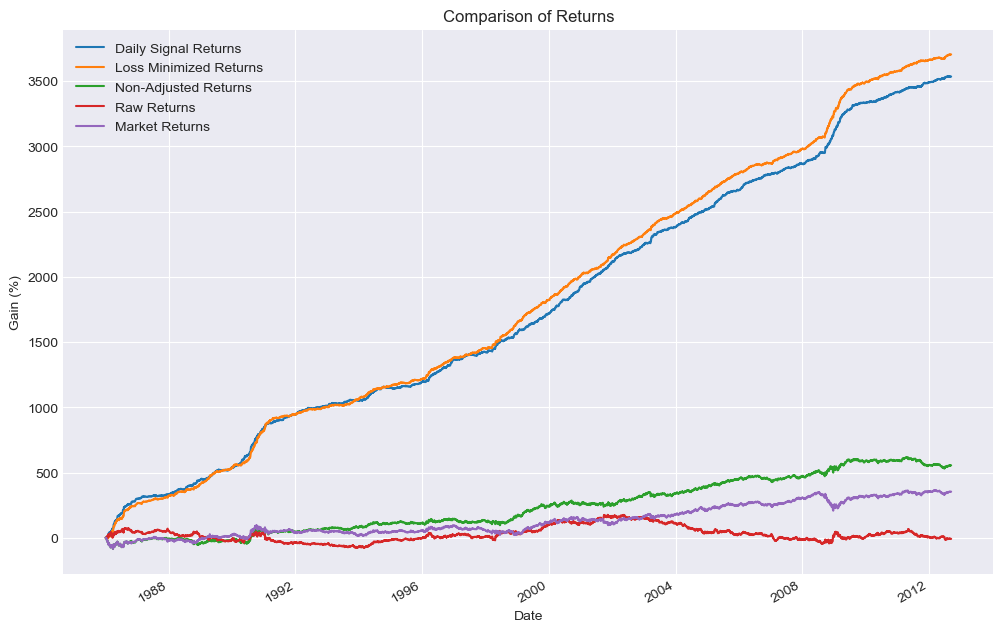

In [ ]:
returns_cols = ['d_sig_returns', 'filtered_strategy_returns', 'strategy_returns', 'actual_returns','market_returns']
labels = ['Daily Signal Returns', 'Loss Minimized Returns', 'Non-Adjusted Returns', 'Raw Returns','Market Returns']
backtest[returns_cols].cumsum().plot(figsize = (12,8))
plt.title('Comparison of Returns')
plt.ylabel('Gain (%)')
plt.legend(labels = labels)

The figure above shows a brief comparison of returns for trading Crude Oil.

filtered_strategy_returns: indicates the returns of a strategy where it cuts losses at -1.5% loss. This would indicate that cutting losses immediately, significantly outperforms the times when losses are not mitigated. 

In [ ]:
strat = 'filtered_strategy_returns'

drawdown = backtest.loc[backtest[strat] < 0][[strat]]
gain = backtest.loc[backtest[strat] > 0][[strat]]


(-5.0, 5.0)

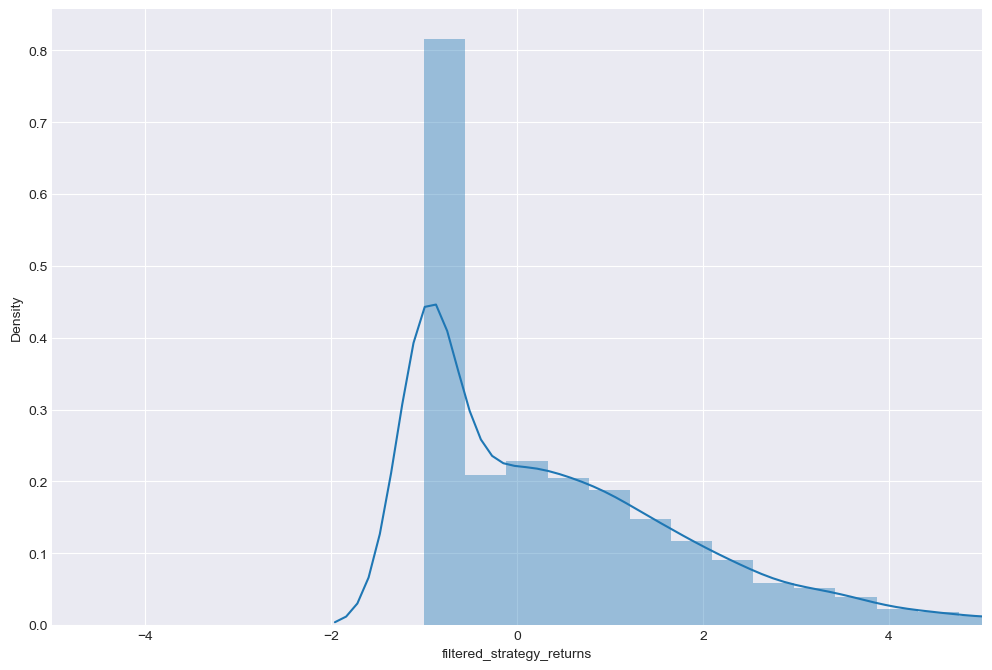

In [ ]:
plt.figure(figsize = (12, 8))
sns.distplot(backtest[strat])
plt.xlim((-5, 5))

#### A BRIEF SUMMARY

The current backtest configuration yields a 52% win rate with a mean gain of 1.8% and a mean loss of 0.7%. 

In [ ]:
t = ['gain', 'loss']
g_summary = gain.describe()
l_summary = drawdown.describe()
summary = pd.concat([g_summary,l_summary], axis = 1)
summary.columns = t
summary

,gain,loss
count,3431.000000,3179.000000
mean,1.815447,-0.793927
std,1.860016,0.305148
min,0.011780,-1.000000
25%,0.627720,-1.000000
50%,1.319648,-1.000000
75%,2.380952,-0.593774
max,21.107266,-0.010306


The overall performance of the test yields a 51% prediction accuracy. 

In [ ]:

correct_prediction = backtest.loc[backtest['signal'] == backtest['signal_actual']]['signal'].count()
total_predictions = backtest['signal'].count()
print('Correct Predictions: ', correct_prediction)
print('Total Predictions: ', total_predictions)
print('Accuracy Score: ', accuracy_score(backtest['signal_actual'], backtest['signal']))

Correct Predictions:  3470
Total Predictions:  6734
Accuracy Score:  0.5152955152955153


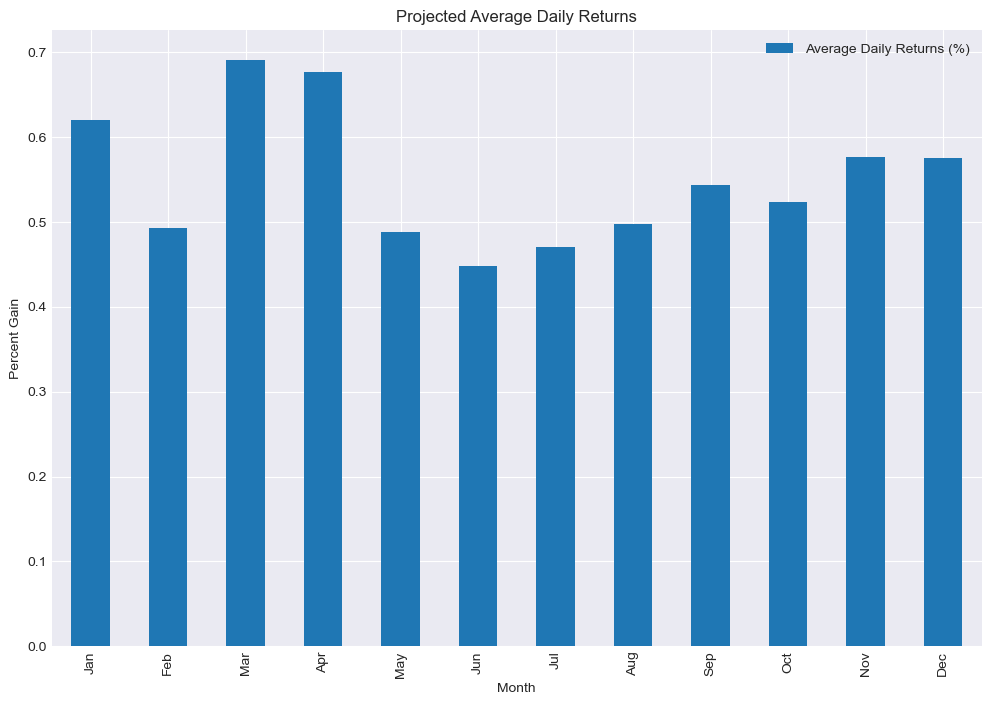

In [ ]:
returns = backtest.groupby(backtest.index.month).mean()[[strat]]
returns.index = returns.index.map({k+1:v for k,v in enumerate(months)})
returns.plot(kind = 'bar', grid = True, title = 'Projected Average Daily Returns', label = 'Returns', figsize = (12, 8))
plt.ylabel('Percent Gain')
plt.xlabel('Month')
plt.legend(labels = ['Average Daily Returns (%)'])

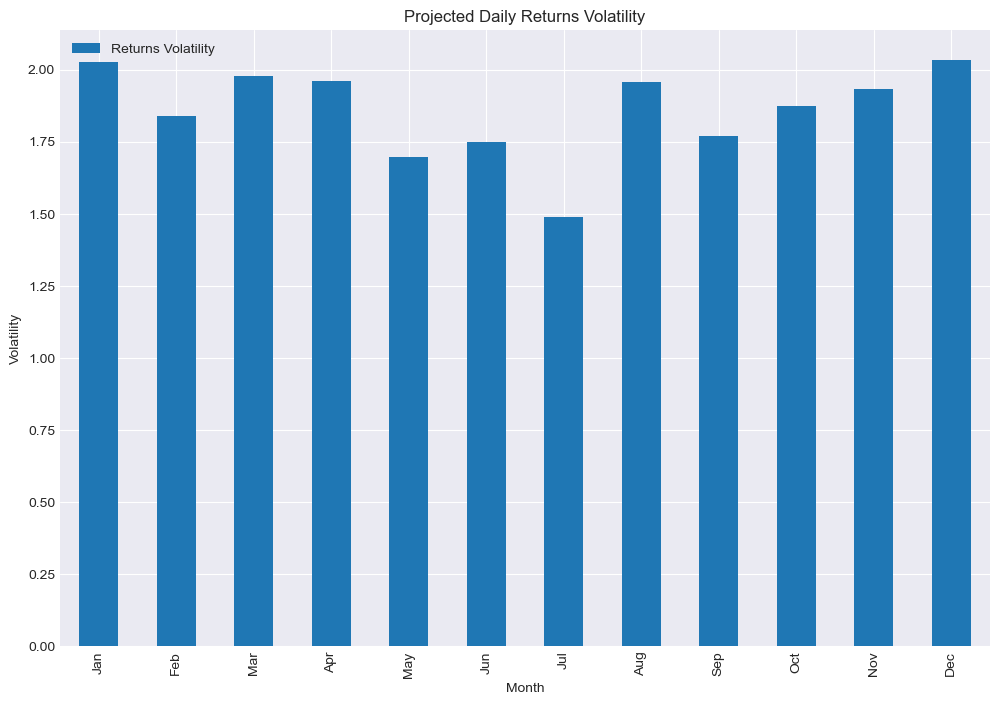

In [ ]:
returns_volatility = backtest.groupby(backtest.index.month).std()[[strat]]
returns_volatility.index = returns_volatility.index.map({k+1:v for k,v in enumerate(months)})
returns_volatility.plot(kind = 'bar', grid = True, title = 'Projected Daily Returns Volatility', label = 'Returns', figsize = (12, 8))
plt.ylabel('Volatility')
plt.xlabel('Month')
plt.legend(labels = ['Returns Volatility'])

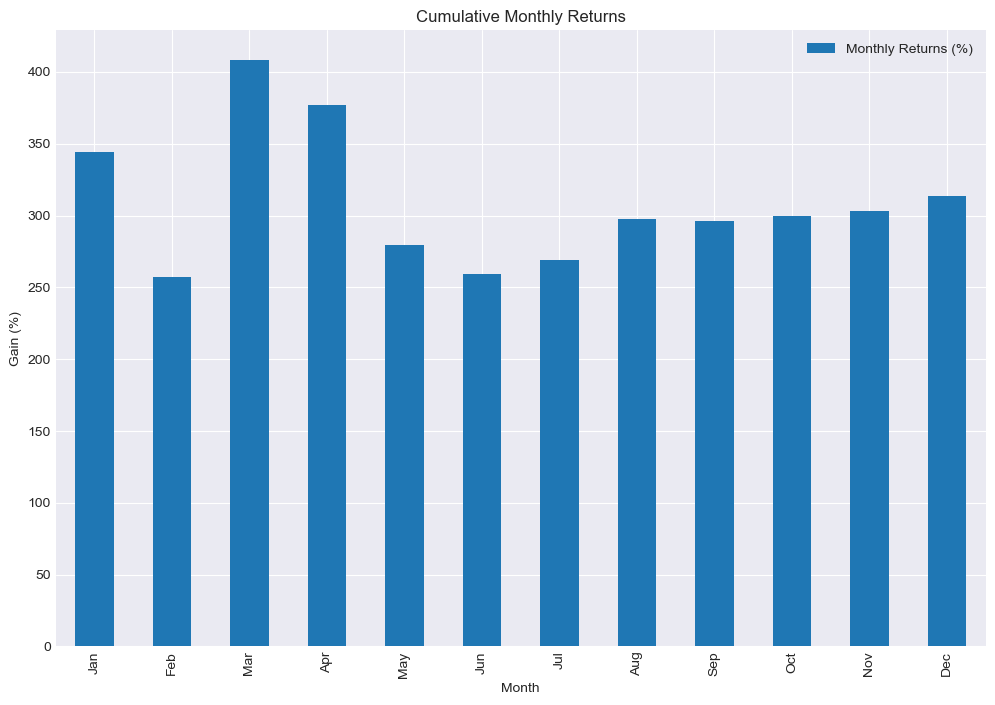

In [ ]:
returns_monthly = backtest[[strat]].groupby(backtest.index.month).sum()
returns_monthly.index = returns_monthly.index.map({k+1:v for k,v in enumerate(months)})
returns_monthly.plot(kind = 'bar', grid = True, title = 'Cumulative Monthly Returns', figsize = (12, 8))
plt.ylabel('Gain (%)')
plt.xlabel('Month')
plt.legend(labels = ['Monthly Returns (%)'])

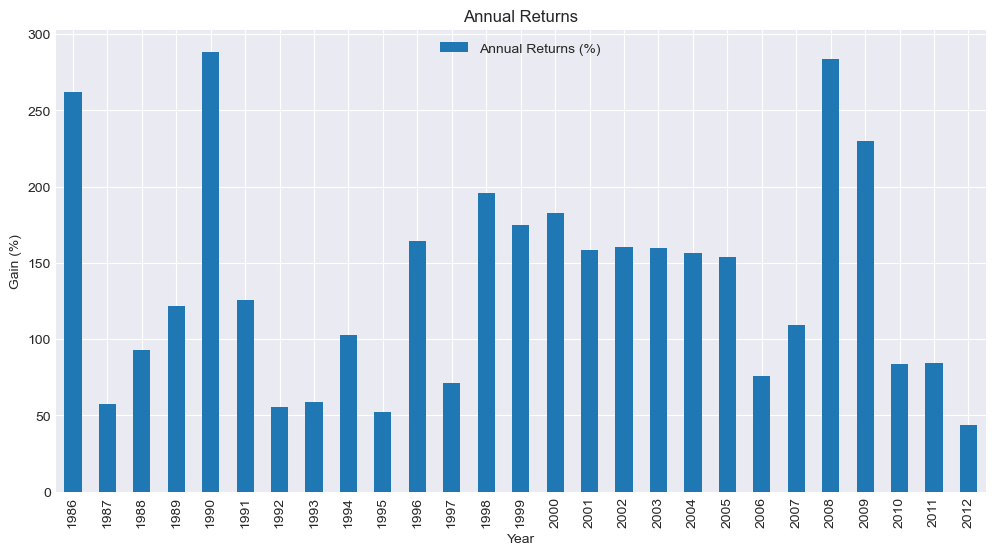

In [ ]:
returns_annual = backtest[[strat]].groupby(backtest.index.year).sum()
returns_annual.plot(kind = 'bar', grid = True, figsize = (12, 6), title = 'Annual Returns')
plt.xlabel('Year')
plt.ylabel('Gain (%)')
plt.legend(labels = ['Annual Returns (%)'])

#### ANNUAL RETURNS

Overall, the strategy shows promising results across multiple time horizons, and displays acceptable annual returns from both long and short positions

#### VALIDATION ON TEST SET 

The test set to be used for validation will be the data from 2021 - 2022, with the exclusion of the 2020 Covid Crash. 

Signals for the test set are created in the same manner from the training set.

In [ ]:

validation = crude_d.loc[crude_d.index < dt(2020,1,1)][-test_size:]

val_backtest = run_backtest(validation)
val_backtest

,Close,pct_change,signal,daily_sig,signal_actual,match,market_returns,strategy_returns,actual_returns,d_sig_returns,filtered_strategy_returns
Date,,,,,,,,,,,
2012-09-14,98.94,0.651068,1,1,1,1,0.651068,0.651068,0.651068,0.651068,0.651068
2012-09-17,96.51,-2.456034,1,-1,-1,0,-2.456034,-2.456034,-2.456034,-1.000000,-1.000000
2012-09-18,95.25,-1.305564,1,-1,-1,0,-1.305564,-1.305564,1.305564,1.305564,-1.000000
2012-09-19,91.97,-3.443570,1,1,-1,0,-3.443570,-3.443570,3.443570,3.443570,-1.000000
2012-09-20,92.14,0.184843,1,1,1,1,0.184843,0.184843,-0.184843,0.184843,0.184843
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,61.17,1.090729,1,-1,1,1,1.090729,1.090729,1.090729,-1.000000,1.090729
2019-12-26,61.72,0.899134,1,1,1,1,0.899134,0.899134,0.899134,-0.899134,0.899134
2019-12-27,61.76,0.064809,1,1,1,1,0.064809,0.064809,0.064809,0.064809,0.064809


In terms of accuracy, the test set shows better performance compared the train set, which shows that the signals overall yield a positive effect on unseen data.

In [ ]:

correct_prediction = val_backtest.loc[val_backtest['signal'] == val_backtest['signal_actual']]['signal'].count()
total_predictions = val_backtest['signal'].count()
print('Correct Predictions: ', correct_prediction)
print('Total Predictions: ', total_predictions)
print('Accuracy Score: ', accuracy_score(val_backtest['signal_actual'], val_backtest['signal']))

Correct Predictions:  971
Total Predictions:  1832
Accuracy Score:  0.5300218340611353


#### PLOTTING TEST SET RETURNS

The test set outperforms market returns in the same manner as with the train set, showing profitable returns similar to the previous results.

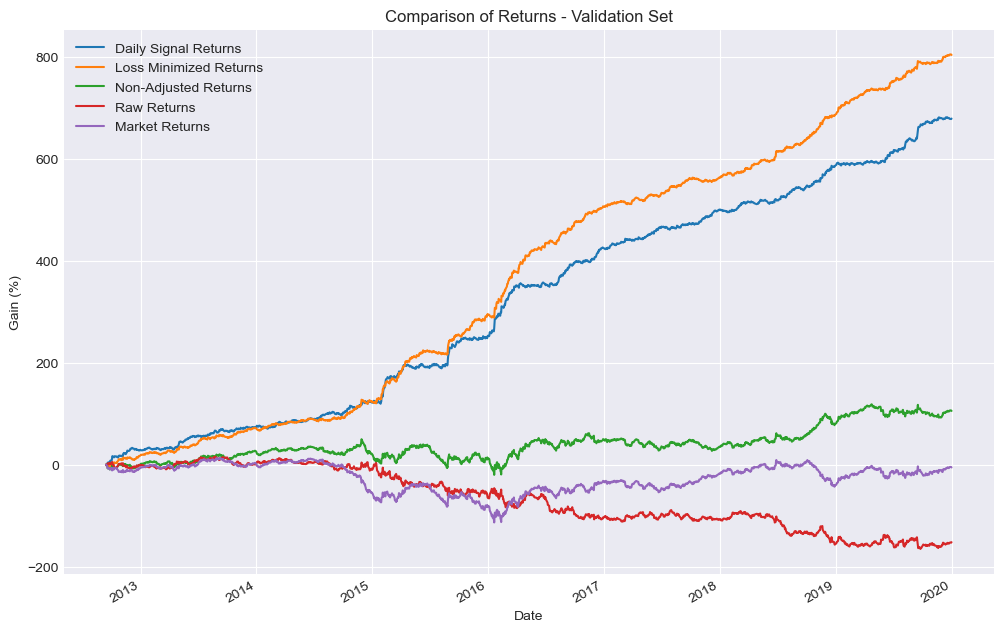

In [ ]:
returns_cols = ['d_sig_returns', 'filtered_strategy_returns', 'strategy_returns', 'actual_returns','market_returns']
labels = ['Daily Signal Returns', 'Loss Minimized Returns', 'Non-Adjusted Returns', 'Raw Returns','Market Returns']
val_backtest[returns_cols].cumsum().plot(figsize = (12, 8))
plt.title('Comparison of Returns - Validation Set')
plt.ylabel('Gain (%)')
plt.legend(labels = labels)

In [ ]:
drawdown = val_backtest.loc[val_backtest[strat] < 0][[strat]]
gain = val_backtest.loc[val_backtest[strat] > 0 ][[strat]]

In [ ]:
t = ['gain', 'loss']
g_summary = gain.describe()
l_summary = drawdown.describe()
summary = pd.concat([g_summary,l_summary], axis = 1)
summary.columns = t
summary


,gain,loss
count,957.000000,863.000000
mean,1.516347,-0.750323
std,1.585000,0.332797
min,0.009643,-1.000000
25%,0.490798,-1.000000
50%,1.075479,-1.000000
75%,2.023576,-0.485808
max,15.230095,-0.009428


Over the duration of the test, the strategy yields positive returns on a daily average.

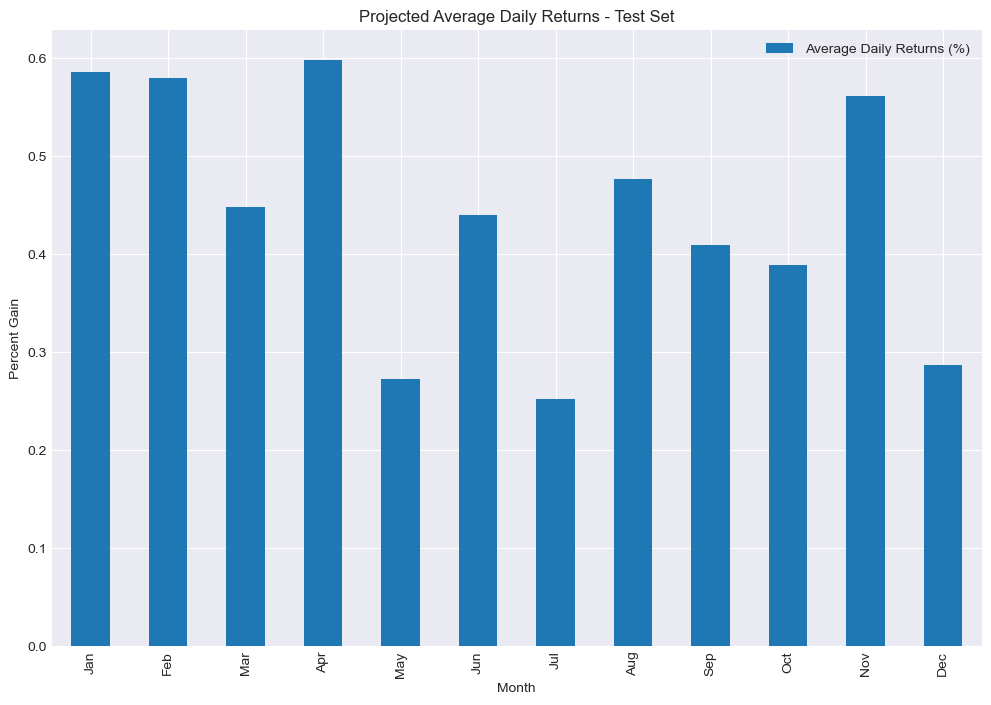

In [ ]:
returns = val_backtest.groupby(val_backtest.index.month).mean()[[strat]]
returns.index = returns.index.map({k+1:v for k,v in enumerate(months)})
returns.plot(kind = 'bar', grid = True, title = 'Projected Average Daily Returns - Test Set', label = 'Returns', figsize = (12, 8))
plt.ylabel('Percent Gain')
plt.xlabel('Month')
plt.legend(labels = ['Average Daily Returns (%)'])

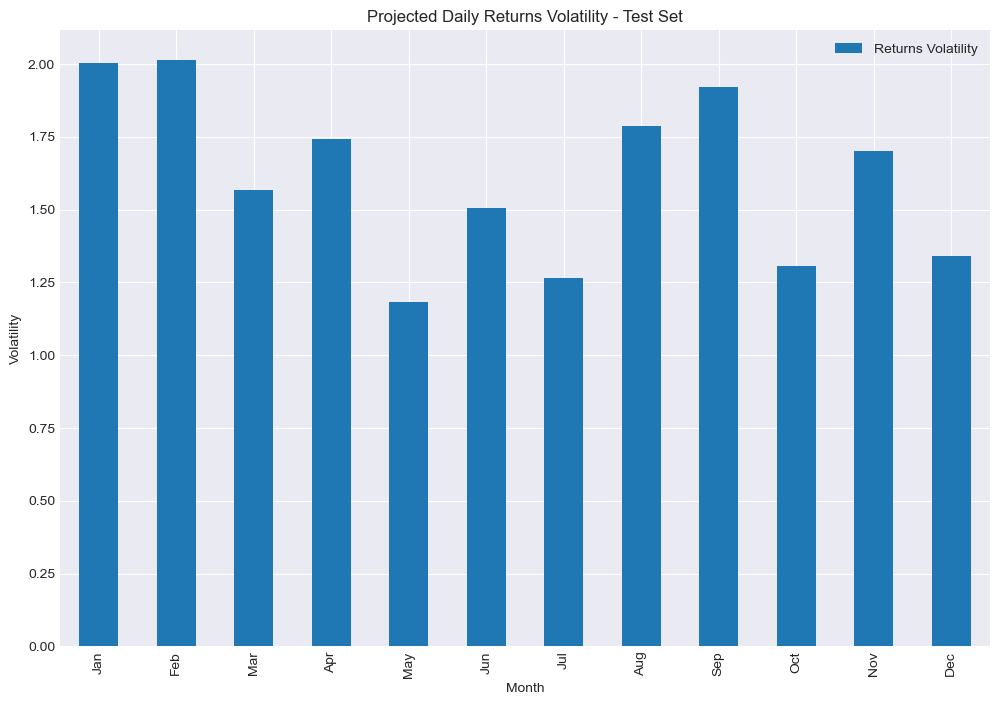

In [ ]:
returns_volatility = val_backtest.groupby(val_backtest.index.month).std()[[strat]]
returns_volatility.index = returns_volatility.index.map({k+1:v for k,v in enumerate(months)})
returns_volatility.plot(kind = 'bar', grid = True, title = 'Projected Daily Returns Volatility - Test Set', label = 'Returns', figsize = (12, 8))
plt.ylabel('Volatility')
plt.xlabel('Month')
plt.legend(labels = ['Returns Volatility'])

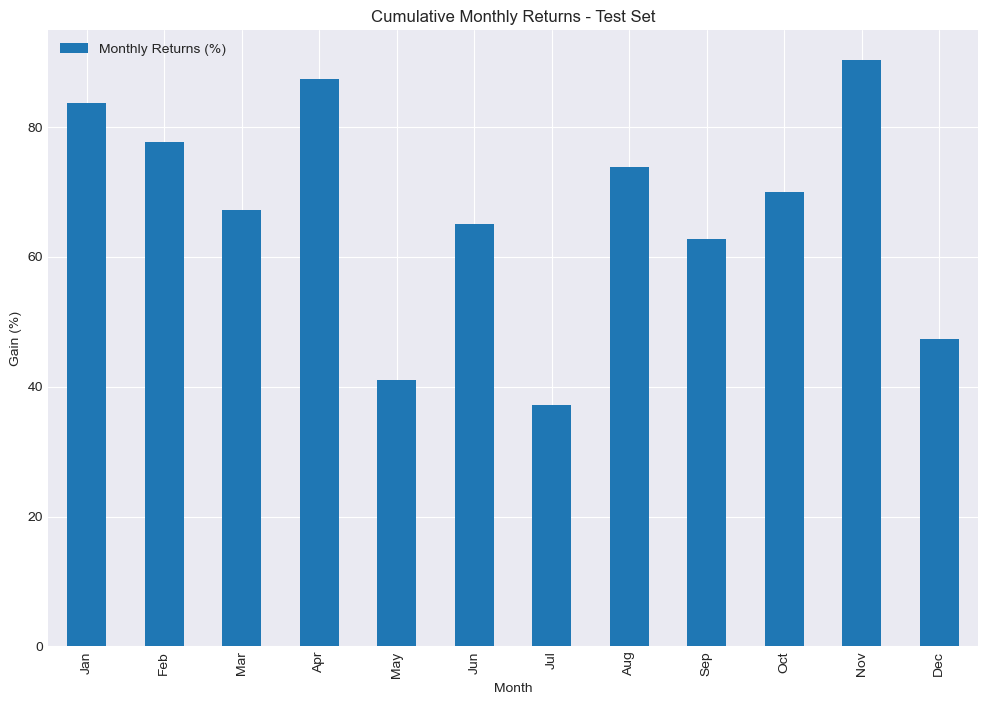

In [ ]:
returns_monthly = val_backtest[[strat]].groupby(val_backtest.index.month).sum()
returns_monthly.index = returns_monthly.index.map({k+1:v for k,v in enumerate(months)})
returns_monthly.plot(kind = 'bar', grid = True, title = 'Cumulative Monthly Returns - Test Set', figsize = (12, 8))
plt.ylabel('Gain (%)')
plt.xlabel('Month')
plt.legend(labels = ['Monthly Returns (%)'])

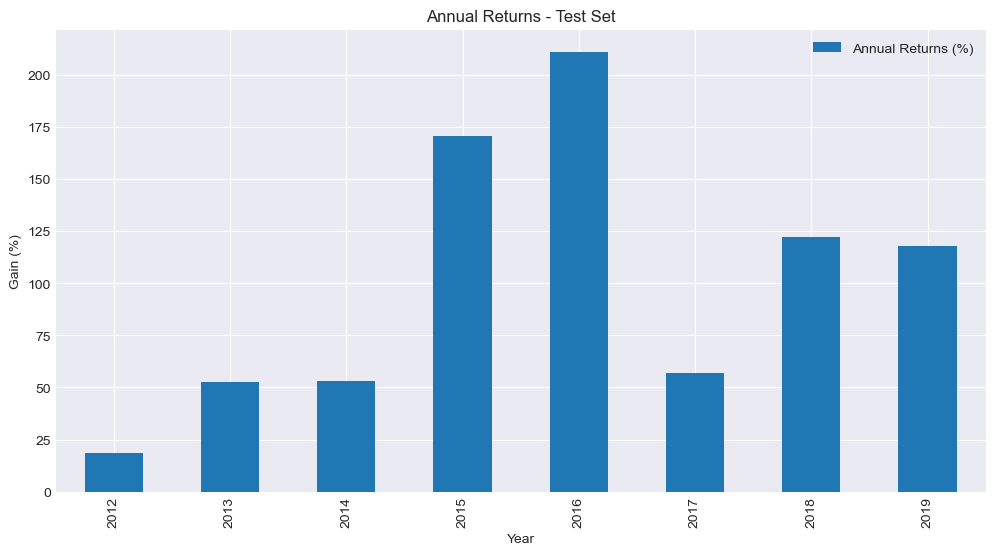

In [ ]:
returns_annual = val_backtest[[strat]].groupby(val_backtest.index.year).sum()
returns_annual.plot(kind = 'bar', grid = True, figsize = (12, 6), title = 'Annual Returns - Test Set')
plt.xlabel('Year')
plt.ylabel('Gain (%)')
plt.legend(labels = ['Annual Returns (%)'])

#### CONCLUSION 

An alpha based purely on seasonality shows promising results based on initial investigation. The test set responds well to the recommendations of the training set, with a better win rate. 

Implementing trading decisions based on this study would possibly yield profitable results over the long run. However, it is recommended to implement any additional intraday optimization or entry price selection to maximize returns. 

#### LIMITATIONS

The strategy is sensitive to black-swan events, sudden crashes, geopolitical issues, or anything outside of the normal supply and demand conditions.

Transaction costs and bid-ask spread have not been taken into consideration in this study, both of which, may have an impact as to how the overall strategy performs in live market conditions. 

Intraday volatility was also not taken into consideration in this test, which, would most likely impact the overall performance.